# Pydeep Recsys

<p><center><img src='_images/T616640_1.png'></center></p>

The `ReinforcementLearning` abstract class defines what functions agents are expected to have. Namely, to predict the next action to be taken on a given state, the next k best actions (for slate environments), and to store a particular experience (i.e., a state, action, reward, done, next observed state) tuple.

The `BaseNetwork` base class implements helper functions like saving and loading from a file, freezing specific parameters, running backward propagation of a loss, plotting the gradient graph, configuring the hardware device (i.e., CPU or GPU).

`LearningStatistics` module helps collect different metrics that agents may output while training, providing ways to retrieve, plot, and aggregate them on many levels (i.e., model, episode, time-step, environment).

`Manager` module coordinates the sending and receiving of actions and states. Managers help with training agents, hyperparameter search, executing episodes, and printing overviews of environments.

## Setup

In [ ]:
!git clone https://github.com/luksfarris/pydeeprecsys.git pydeeprecsys
%cd pydeeprecsys

In [ ]:
# !curl -sSL https://raw.githubusercontent.com/python-poetry/poetry/master/install-poetry.py | python -
# !/root/.local/bin/poetry show

In [ ]:
# prepare submodules
!git submodule init
!git submodule update --remote
# install ml fairness using custom setup script
!python mlfairnessgym.setup.py install
# download movielens data
!python -m mlfairnessgym.environments.recommenders.download_movielens

## MovieLens Fairness Gym Environment

In [ ]:
!pip install recsim simplejson

In [ ]:
# we start by importing the environment module
from pydeeprecsys.movielens_fairness_env import MovieLensFairness
import gym
# then we can create a gym environment with a particular slate size
env = gym.make('MovieLensFairness-v0', slate_size=3)
type(env)

gym.wrappers.time_limit.TimeLimit

Now we can understand what are states, actions and rewards in this environment. Let's start with state

In [ ]:
env.observation_space

Box(0.0, 1.0, (25,), float32)

So we have 25 variables, in the (0,1) range:

- 4 variables represent scaled (sex, age, occupation, zip code)
- 19 variables, that are one-hot encodings for the category of the latest reviewed movie. Categories include Action, Crime, Thriller, and so on
- 1 variable for the user's 5 star rating.
- 1 variable for the movie's violence score.

Let's see how they look like

In [ ]:
env.reset()

array([0.        , 0.01785714, 0.1       , 0.60660607, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

As you can see, the first 4 variables are set. Under the hood, the environment sampled a user from the user pool, and prepared it. The remaining variables are 0 because no movie has been recommended yet. Let's see how recommendations are made:

In [ ]:
env.action_space

MultiDiscrete([3883 3883 3883])

Since we set our slate_size to 3, this means that at each step the agent must recommend 3 movies. Recommendations are made based on the (discrete) movie identifier, that's why the action space is of type MultiDiscrete. 3883 is the amount of available movies. Let's make a recommendation:

In [ ]:
random_slate = env.action_space.sample()
random_slate

array([ 152, 1843, 2778])

In [ ]:
state, reward, done, info = env.step(random_slate)

After receiving a recommendation, the user makes a choice, and reviews the movie. Thanks to Recsim and MLFairnessGym we can:

- affect the behavior of users after being exposed to movies, by encoding addiction/boredom dynamics into the user embedding
- encode the violence score into the reward, so that recommending too many violent movies brings a negative reward

Let's see the new state:

In [ ]:
state

array([0.        , 0.01785714, 0.1       , 0.60660607, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.55230223, 0.        ])

We can also inspect the reward, which is in range (0,1):

In [ ]:
reward

0.43209501042800574

And we can check if the episode is done. Currently, episodes are finished when the simulated user has rated 50 movies.

In [ ]:
done

False

## Training a Random Agent

The Manager class facilitates a lot of things like training, hyperparameter optimization, and so on.

In [ ]:
!pip install highway_env

In [ ]:
from pydeeprecsys.rl.manager import MovieLensFairnessManager
from pydeeprecsys.rl.agents.agent import RandomAgent
from pydeeprecsys.rl.learning_statistics import LearningStatistics

In [ ]:
manager = MovieLensFairnessManager(slate_size=1)
manager.print_overview()

Reward threshold: inf 
Reward signal range: (-inf, inf) 
Maximum episode steps: 50 
Action apace size: Discrete(3883)
Observation space size Box(0.0, 1.0, (25,), float32) 


In [ ]:
agent = RandomAgent(action_space=manager.env.action_space)
stats = LearningStatistics()
manager.train(agent, stats, max_episodes=200, should_print=True)

Training...
Episode 199 Mean Rewards 31.38 Last Reward 18.44		

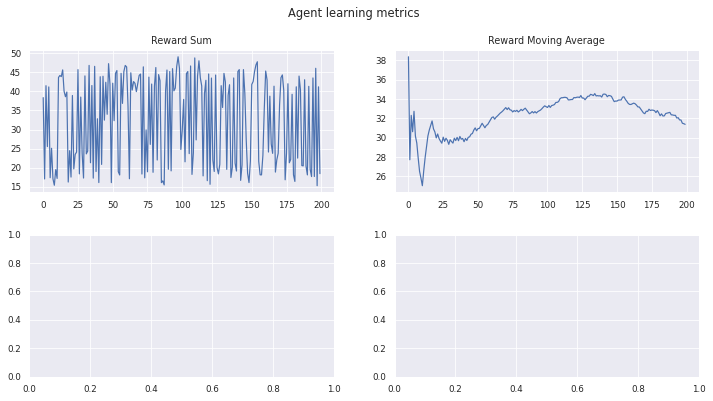

In [ ]:
stats.plot_learning_stats()

## Experience Replay

In [ ]:
import numpy as np
from numpy.random import RandomState
from abc import ABC, abstractmethod
from collections import namedtuple, deque
from typing import List, Tuple, Any

In [ ]:
Experience = namedtuple(
    "Experience", field_names=["state", "action", "reward", "done", "next_state"]
)

PriorityExperience = namedtuple(
    "PriorityExperience", field_names=["experience", "priority"]
)

In [ ]:
class ExperienceReplayBufferParameters:
    """ Parameters to configure an experience replay buffer. """

    def __init__(
        self,
        max_experiences: int = 50,
        minimum_experiences_to_start_predicting: int = 32,
        batch_size: int = 32,
        random_state: RandomState = RandomState(),
    ):
        if minimum_experiences_to_start_predicting < batch_size:
            raise ValueError("The batch size mus the larger than the burn in")
        self.max_experiences = max_experiences
        self.minimum_experiences_to_start_predicting = (
            minimum_experiences_to_start_predicting
        )
        self.batch_size = batch_size
        self.random_state = random_state

In [ ]:
class PERBufferParameters:
    """Parameters to configure the priorititization of experiences in a
    Prioritized-Experience Replay Buffer"""

    def __init__(
        self,
        beta: float = 0.01,
        beta_growth: float = 0.001,
        alpha: float = 0.6,
        epsilon: float = 0.01,
    ):
        self.beta = beta
        self.beta_growth = beta_growth
        self.alpha = alpha
        self.epsilon = epsilon

In [ ]:
class ExperienceBuffer(ABC):
    @abstractmethod
    def ready_to_predict(self) -> bool:
        pass

    @abstractmethod
    def sample_batch(self) -> List[Tuple]:
        pass

    @abstractmethod
    def store_experience(
        self, state: Any, action: Any, reward: float, done: bool, next_state: Any
    ):
        pass

In [ ]:
class ExperienceReplayBuffer(ExperienceBuffer):
    def __init__(
        self,
        parameters=ExperienceReplayBufferParameters(),
    ):
        self.minimum_experiences_to_start_predicting = (
            parameters.minimum_experiences_to_start_predicting
        )
        self.random_state = parameters.random_state
        # create double ended queue to store the experiences
        self.experience_queue = deque(maxlen=parameters.max_experiences)
        self.batch_size = parameters.batch_size

    def sample_batch(self) -> List[Tuple]:
        """ Samples a given number of experiences from the queue """
        # samples the index of `batch_size` different experiences from the replay memory
        samples = self.random_state.choice(
            len(self.experience_queue), self.batch_size, replace=False
        )
        # get the experiences
        experiences = [self.experience_queue[i] for i in samples]
        # returns a flattened list of the samples
        return zip(*experiences)

    def store_experience(
        self, state: Any, action: Any, reward: float, done: bool, next_state: Any
    ):
        """ Stores a new experience in the queue """
        experience = Experience(state, action, reward, done, next_state)
        # append to the right (end) of the queue
        self.experience_queue.append(experience)

    def ready_to_predict(self):
        """Returns true only if we had enough experiences to start predicting
        (measured by the burn in)"""
        return (
            len(self.experience_queue) >= self.minimum_experiences_to_start_predicting
        )

In [ ]:
class PrioritizedExperienceReplayBuffer(ExperienceReplayBuffer):
    def __init__(
        self,
        buffer_parameters=ExperienceReplayBufferParameters(),
        per_parameters=PERBufferParameters(),
    ):
        super().__init__(buffer_parameters)
        # beta controls the effect of the weights (how much to learn from each
        # experience in the batch)
        self.beta = per_parameters.beta
        self.beta_growth = per_parameters.beta_growth
        # alpha controls the effect of the priority (how much priority is affected
        # by the loss)
        self.alpha = per_parameters.alpha
        # epsilon guarantees no experience has priority zero
        self.epsilon = per_parameters.epsilon

    def priorities(self) -> np.array:
        """ Gets the priority for each experience in the queue """
        return np.array(
            [e.priority for e in self.experience_queue], dtype=np.float32
        )

    def store_experience(
        self, state: Any, action: Any, reward: float, done: bool, next_state: Any
    ):
        """We include a priority to the experience. if the queue is empty, priority is 1 (max),
        otherwise we check the maximum priority in the queue"""
        priorities = self.priorities()
        priority = priorities.max() if len(priorities) > 0 else 1.0
        if not np.isnan(priority):
            experience = Experience(state, action, reward, done, next_state)
            priority_experience = PriorityExperience(experience, priority)
            # append to the right (end) of the queue
            self.experience_queue.append(priority_experience)

    def update_beta(self):
        """We want to grow the beta value slowly and linearly, starting at a value
        close to zero, and stopping at 1.0. This is for the Importance Sampling"""
        if self.beta < 1.0:
            self.beta += self.beta_growth

    def update_priorities(self, batch: List[Tuple], errors_from_batch: List[float]):
        """We want the priority of elements to be the TD error of plus an epsilon
        constant. The epsilon constant makes sure that no experience ever gets a
        priority zero. This prioritization strategy gives more importance to
        elements that bring more learning to the network."""
        experience_indexes = [b[-1] for b in np.array(batch, dtype=np.object).T]
        for i in range(len(experience_indexes)):
            error = abs(errors_from_batch[i]) + self.epsilon
            if not np.isnan(error):
                self.experience_queue[experience_indexes[i]] = self.experience_queue[
                    experience_indexes[i]
                ]._replace(priority=error)

    def sample_batch(self) -> List[Tuple]:
        """We sample experiences using their priorities as weights for sampling. The
        effect of the priorities is controlled by the alpha parameter. This is
        already an advantage but it can introduce bias in a network by always
        choosing the same type of experiences for training. In order to fight this, we
        compute the weight of the experience (this is called Importance Sampling,
        or IP). We want the weights to decrease over time, this is controlled by
        the beta parameter."""
        # calculate probabilities (alpha)
        probabilities = self.priorities() ** self.alpha
        p = probabilities / probabilities.sum()
        # sample experiences
        buffer_size = len(self.experience_queue)
        samples = np.random.choice(
            a=buffer_size, size=self.batch_size, p=p, replace=False
        )
        experiences = [self.experience_queue[i].experience for i in samples]
        # importance Sampling
        # w_i = (1/N * 1/P_i) ^ beta
        weights = ((1 / buffer_size) * (1 / p[samples])) ** self.beta
        weights = weights / weights.max()
        self.update_beta()
        # return experiences with weights
        return list(zip(*experiences)) + [tuple(weights)] + [tuple(samples)]

## Learning statictics

In [ ]:
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
from typing import Any, List, Dict, Optional

sns.set_theme()
sns.set_context("paper")

In [ ]:
class LearningStatistics:
    def __init__(
        self, model_name: Optional[str] = None, env_name: Optional[str] = None
    ):
        self.collected_metrics: List[Dict] = []
        self.model_name = model_name
        self.env_name = env_name
        self.timestep = 0
        self.episode = 0

    def append_metric(self, metric_name: str, metric_value: Any):
        self.collected_metrics.append(
            {
                "metric": metric_name,
                "measurement": metric_value,
                "timestep": self.timestep,
                "episode": self.episode,
                "model": self.model_name,
                "env": self.env_name,
            }
        )

    def get_metrics(
        self, metric_name: str, model: Optional[str] = None, env: Optional[str] = None
    ) -> Optional[pandas.Series]:
        measurements = [
            v["measurement"]
            for v in self.collected_metrics
            if (v["metric"] == metric_name and v["model"] == model and v["env"] == env)
        ]
        if measurements:
            return pandas.Series(measurements)

    @property
    def moving_rewards(self) -> Optional[pandas.Series]:
        return self.get_metrics("moving_rewards")

    @property
    def episode_rewards(self) -> Optional[pandas.Series]:
        return self.get_metrics("episode_rewards")

    @property
    def epsilon_values(self) -> Optional[pandas.Series]:
        return self.get_metrics("epsilon_values")

    @property
    def loss_values(self) -> Optional[pandas.Series]:
        return self.get_metrics("loss")

    def plot_rewards(self):
        self.episode_rewards.plot()
        self.moving_rewards.plot()

    def plot_learning_stats(self):
        # generate subplots
        fig, axs = plt.subplots(2, 2)
        fig.suptitle("Agent learning metrics")
        fig.set_figheight(6)
        fig.set_figwidth(12)
        fig.subplots_adjust(hspace=0.3)
        # add data to plots
        self.episode_rewards.plot(ax=axs[0][0], title="Reward Sum")
        self.moving_rewards.plot(ax=axs[0][1], title="Reward Moving Average")
        if self.epsilon_values is not None:
            self.epsilon_values.plot(ax=axs[1][1], title="Epsilon Values")
        if self.loss_values is not None:
            self.loss_values.plot(ax=axs[1][0], title="Loss")

## Neural Networks

In [ ]:
!pip install torchviz

In [ ]:
from torch.nn import Module
from torch import save, load
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from torchviz import make_dot
from typing import Any, List
from torch.optim import Adam
from torch.nn import Sequential, Softmax, Linear, Tanh
from torch import FloatTensor, multinomial, Tensor
from torch import sum as torch_sum
from torch.distributions import Categorical
from torch import FloatTensor, max, LongTensor, BoolTensor, gather, Tensor
from numpy import array, ravel
from torch.nn import Sequential, Linear, ReLU, MSELoss, Module
from torch.optim import Adam
from typing import List, Any, Tuple, Optional
from torch.nn import Linear, Parameter, functional

In [ ]:
def sequential_architecture(layers: List[int], bias: bool = True) -> Module:
    """ Fully connected layers, with bias, and ReLU activation"""
    architecture = []
    for i in range(len(layers) - 2):
        architecture.append(Linear(layers[i], layers[i + 1], bias=bias))
        architecture.append(ReLU())
    architecture.append(Linear(layers[-2], layers[-1], bias=bias))
    return Sequential(*architecture)

In [ ]:
class NoisyLayer(Linear):
    def __init__(
        self, in_features: int, out_features: int, bias=True, sigma: float = 0.017
    ):
        super().__init__(in_features, out_features, bias=bias)
        self.sigma_weight = Parameter(torch.full((out_features, in_features), sigma))
        self.register_buffer("epsilon_weight", torch.zeros(out_features, in_features))
        if bias:
            self.sigma_bias = Parameter(torch.full((out_features,), sigma))
            self.register_buffer("epsilon_bias", torch.zeros(out_features))

    def forward(self, input):
        """At every forward operation, feeds the weights and biases with normally
        distributed random variables with mean zero and std deviation 1. This means
        the bias and the weights will have a noise of:
        sigma (constant) * epsilon (random in range(-1,1))"""
        self.epsilon_weight.normal_()
        bias = self.bias
        if bias is not None:
            self.epsilon_bias.normal_()
            bias = bias + self.sigma_bias * self.epsilon_bias.clone()
        return functional.linear(
            input, self.weight + self.sigma_weight * self.epsilon_weight.clone(), bias
        )

In [ ]:
class BaseNetwork(Module):
    def __init__(self):
        super().__init__()
        self.device = self._auto_detect_device()

    @staticmethod
    def _auto_detect_device():
        has_cuda = torch.cuda.is_available() and torch.cuda.is_initialized()
        return torch.device("cuda" if has_cuda else "cpu")

    def save(self, path: str):
        """ Writes the model's parameters to the given path. """
        save(self.state_dict(), path)

    def load(self, path: str):
        """ Reads the model's parameters from the given path. """
        self.load_state_dict(load(path))

    def soft_parameter_update(self, source_network: Module, update_rate: float = 0.0):
        """When using target networks, this method updates the parameters of the current network
        using the parameters of the given source network. The update_rate is a float in
        range (0,1) and controls how the update affects the target (self). update_rate=0
        means a full deep copy, and update_rate=1 means the target does not update
        at all. This parameter is usually called Tau. This method is usually called
        an exponential moving average update."""
        for t, s in zip(self.parameters(), source_network.parameters()):
            t.data.copy_(t.data * (1.0 - update_rate) + s.data * update_rate)

    def run_backpropagation(self, loss):
        """Requires an optimizer property. Runs backward on the given loss, and
        steps the optimizer."""
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def disable_learning(self):
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, *input):
        return self.model(*input)

    def add_to_tensorboard(self, input_example: np.array):
        writer = SummaryWriter(f"output/writer/{type(self).__name__}")
        tensor = torch.FloatTensor(input_example)
        writer.add_graph(self, tensor, verbose=True)
        writer.close()
        graph = make_dot(
            self.forward(tensor),
            params=dict(self.named_parameters()),
            show_attrs=True,
            show_saved=True,
        )
        graph.format = "pdf"
        graph.render(f"output/graphs/{type(self).__name__}")

In [ ]:
class PolicyEstimator(BaseNetwork):
    """Estimates the policy function: the probability of each action being the
    best decision in a particular state."""

    def __init__(
        self,
        input_size: int,
        hidden_layers: List[int],
        output_size: int,
        learning_rate=1e-2,
    ):
        super().__init__()
        layers = [input_size] + hidden_layers + [output_size]
        architecture = []
        for i in range(len(layers) - 2):
            architecture.append(Linear(layers[i], layers[i + 1]))
            architecture.append(Tanh())
        architecture.append(Linear(layers[-2], layers[-1]))
        architecture.append(Softmax(dim=-1))
        self.model = Sequential(*architecture)
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        if self.device == "cuda":
            self.model.cuda()

    def action_probabilities(self, state: Any):
        return self.model(FloatTensor(state))

    def predict(self, state: Any, k: int = 1) -> List[int]:
        probabilities = self.action_probabilities(state)
        prediction = multinomial(probabilities, num_samples=k, replacement=False)
        if self.device == "cuda":
            return prediction.detach().cpu().numpy()
        else:
            return prediction.detach().numpy()

    def update(self, state: np.array, reward_baseline: Tensor, action: np.array):
        state_tensor = FloatTensor(state).to(device=self.device)
        action_tensor = FloatTensor(np.array(action, dtype=np.float32)).to(
            device=self.device
        )
        """ Update logic from the Policy Gradient theorem. """
        action_probabilities = self.model(state_tensor)
        action_distribution = Categorical(action_probabilities)
        selected_log_probabilities = action_distribution.log_prob(action_tensor)
        loss = torch_sum(-selected_log_probabilities * reward_baseline)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.device == "cuda":
            return loss.detach().cpu().numpy()
        else:
            return loss.detach().numpy()

In [ ]:
class DeepQNetwork(BaseNetwork):
    """Implementation of a Deep Q Network with a Sequential arquitecture. Layers are
    supposed to be provided as a list of torch modules."""

    def __init__(
        self,
        learning_rate: float,
        architecture: Module,
        discount_factor: float = 0.99,
        statistics: Optional[LearningStatistics] = None,
    ):
        super().__init__()
        self.model = architecture
        self.discount_factor = discount_factor
        self.statistics = statistics
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        if self.device == "cuda":
            self.model.cuda()

    def best_action_for_state(self, state: Any) -> Any:
        if type(state) is tuple:
            state = array([ravel(s) for s in state])
        state_tensor = FloatTensor(state).to(device=self.device)
        q_values = self.model(state_tensor)
        best_action = max(q_values, dim=-1)[1].item()
        return best_action

    def learn_from(self, experiences: List[Tuple]):
        self.optimizer.zero_grad()
        loss = self._calculate_loss(experiences)
        loss.backward()
        self.optimizer.step()
        # store loss in statistics
        if self.statistics:
            if self.device == "cuda":
                self.statistics.append_metric("loss", loss.detach().cpu().numpy())
            else:
                self.statistics.append_metric("loss", loss.detach().numpy())

    def _calculate_loss(self, experiences: List[Tuple]) -> Tensor:
        states, actions, rewards, dones, next_states = [i for i in experiences]
        state_tensors = FloatTensor(states).to(device=self.device)
        next_state_tensors = FloatTensor(next_states).to(device=self.device)
        reward_tensors = FloatTensor(rewards).to(device=self.device).reshape(-1, 1)
        action_tensors = (
            LongTensor(array(actions)).reshape(-1, 1).to(device=self.device)
        )
        done_tensors = BoolTensor(dones).to(device=self.device)
        actions_for_states = self.model(state_tensors)
        q_vals = gather(actions_for_states, 1, action_tensors)
        next_actions = [self.best_action_for_state(s) for s in next_states]
        next_action_tensors = (
            LongTensor(next_actions).reshape(-1, 1).to(device=self.device)
        )
        q_vals_next = gather(self.model(next_state_tensors), 1, next_action_tensors)
        q_vals_next[done_tensors] = 0
        expected_q_vals = self.discount_factor * q_vals_next + reward_tensors
        return MSELoss()(q_vals, expected_q_vals.reshape(-1, 1))

In [ ]:
from torch import FloatTensor, LongTensor, BoolTensor, gather, Tensor
from numpy import array, ravel
from torch.nn import Module, ReLU, Linear, Sequential, functional
from torch.optim import Adam
from typing import List, Any, Tuple, Optional

class DuelingDDQN(BaseNetwork):
    """ Dueling DQN with Double DQN and Noisy Networks """

    def __init__(
        self,
        n_input: int,
        n_output: int,
        learning_rate: float,
        hidden_layers: List[int] = None,
        noise_sigma: float = 0.17,
        discount_factor: float = 0.99,
        statistics: Optional[LearningStatistics] = None,
    ):
        super().__init__()
        if not hidden_layers:
            hidden_layers = [256, 256, 64, 64]
        self.discount_factor = discount_factor
        self._build_network(n_input, n_output, noise_sigma, hidden_layers=hidden_layers)
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        self.statistics = statistics

    def _build_network(
        self, n_input: int, n_output: int, noise_sigma: float, hidden_layers: List[int]
    ):
        """Builds the dueling network with noisy layers, the value
        subnet and the advantage subnet. TODO: add `.to_device()` to Modules"""
        assert len(hidden_layers) == 4
        fc_1, fc_2, value_size, advantage_size = hidden_layers
        self.fully_connected_1 = Linear(n_input, fc_1, bias=True)
        self.fully_connected_2 = NoisyLayer(fc_1, fc_2, bias=True, sigma=noise_sigma)
        self.value_subnet = Sequential(
            NoisyLayer(fc_2, value_size, bias=True, sigma=noise_sigma),
            ReLU(),
            Linear(value_size, 1, bias=True),
        )
        self.advantage_subnet = Sequential(
            NoisyLayer(fc_2, advantage_size, bias=True, sigma=noise_sigma),
            ReLU(),
            Linear(advantage_size, n_output, bias=True),
        )

    def forward(self, state):
        """Calculates the forward between the layers"""
        layer_1_out = functional.relu(self.fully_connected_1(state))
        layer_2_out = functional.relu(self.fully_connected_2(layer_1_out))
        value_of_state = self.value_subnet(layer_2_out)
        advantage_of_state = self.advantage_subnet(layer_2_out)
        # This is the Dueling DQN part
        # Combines V and A to get Q: Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        if len(state.shape) == 2:
            q_values = value_of_state + (
                advantage_of_state - advantage_of_state.mean(dim=1, keepdim=True)
            )
        else:
            q_values = value_of_state + (advantage_of_state - advantage_of_state.mean())
        return q_values

    def get_q_values(self, state: Any) -> Tensor:
        if type(state) is tuple:
            state = array([ravel(s) for s in state])
        state_tensor = FloatTensor(state).to(device=self.device)
        return self.forward(state_tensor)

    def top_k_actions_for_state(self, state: Any, k: int = 1) -> List[int]:
        q_values = self.get_q_values(state)
        _, top_indices = q_values.topk(k=k)
        return [int(v) for v in top_indices.detach().numpy()]  # TODO: cpu() ?

    def learn_with(
        self, buffer: PrioritizedExperienceReplayBuffer, target_network: Module
    ):
        experiences = buffer.sample_batch()
        self.optimizer.zero_grad()
        td_error, weights = self._calculate_td_error_and_weigths(
            experiences, target_network
        )
        loss = (td_error.pow(2) * weights).mean().to(self.device)
        loss.backward()
        self.optimizer.step()
        # store loss in statistics
        if self.statistics:
            if self.device == "cuda":
                self.statistics.append_metric(
                    "loss", float(loss.detach().cpu().numpy())
                )
            else:
                self.statistics.append_metric("loss", float(loss.detach().numpy()))
        # update buffer priorities
        errors_from_batch = td_error.detach().cpu().numpy()
        buffer.update_priorities(experiences, errors_from_batch)

    def _calculate_td_error_and_weigths(
        self, experiences: List[Tuple], target_network: Module
    ) -> Tuple[Tensor, Tensor]:
        states, actions, rewards, dones, next_states, weights, samples = [
            i for i in experiences
        ]
        # convert to tensors
        state_tensors = FloatTensor(states).to(device=self.device)
        next_state_tensors = FloatTensor(next_states).to(device=self.device)
        reward_tensors = FloatTensor(rewards).to(device=self.device).reshape(-1, 1)
        action_tensors = (
            LongTensor(array(actions)).reshape(-1, 1).to(device=self.device)
        )
        done_tensors = BoolTensor(dones).to(device=self.device)
        weight_tensors = FloatTensor(weights).to(device=self.device)
        # the following logic is the DDQN update
        # Then we get the predicted actions for the states that came next
        # (using the main network)
        actions_for_next_states = [
            self.top_k_actions_for_state(s)[0] for s in next_state_tensors
        ]
        actions_for_next_states_tensor = (
            LongTensor(actions_for_next_states).reshape(-1, 1).to(device=self.device)
        )
        # Then we use them to get the estimated Q Values for these next states/actions,
        # according to the target network. Remember that the target network is a copy
        # of this one taken some steps ago
        next_q_values = target_network.forward(next_state_tensors)
        # now we get the q values for the actions that were predicted for the next state
        # we call detach() so no gradient will be backpropagated along this variable
        next_q_values_for_actions = gather(
            next_q_values, 1, actions_for_next_states_tensor
        ).detach()
        # zero value for done timesteps
        next_q_values_for_actions[done_tensors] = 0
        # bellman equation
        expected_q_values = (
            self.discount_factor * next_q_values_for_actions + reward_tensors
        )
        # Then get the Q-Values of the main network for the selected actions
        q_values = gather(self.forward(state_tensors), 1, action_tensors)
        # And compare them (this is the time-difference or TD error)
        td_error = q_values - expected_q_values
        return td_error, weight_tensors.reshape(-1, 1)

In [ ]:
from torch import Tensor, FloatTensor
from torch.nn import Module
from torch.optim import Adam


class QValueEstimator(BaseNetwork):
    """ Estimates the Q-value (expected return) of each (state,action) pair """

    def __init__(self, inputs: int, outputs: int, learning_rate: float = 1e-3):
        super().__init__()
        layers = [inputs] + [inputs * 2, inputs * 2] + [outputs]
        self.model = sequential_architecture(layers)
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        if self.device == "cuda":
            self.model.cuda()

    def predict(self, states: Tensor, actions: Tensor):
        inputs = torch.cat([states, actions.type(FloatTensor)], dim=1).to(
            device=self.device
        )
        return self.model(inputs)


class TwinnedQValueEstimator(BaseNetwork):
    """Estimates the Q-value (expected return) of each (state,action) pair,
    using 2 independent estimators, and predicting with the minimum estimated Q-value"""

    def __init__(self, inputs: int, outputs: int = 1, learning_rate: float = 1e-3):
        super().__init__()
        self.Q1 = QValueEstimator(inputs, outputs, learning_rate=learning_rate)
        self.Q2 = QValueEstimator(inputs, outputs, learning_rate=learning_rate)

    def predict(self, states: Tensor, actions: Tensor):
        q1, q2 = self.forward(states, actions)
        return torch.min(q1, q2)

    def forward(self, states: Tensor, actions: Tensor):
        q1 = self.Q1.predict(states, actions)
        q2 = self.Q2.predict(states, actions)
        return q1, q2

    def calculate_loss(
        self,
        states: Tensor,
        actions: Tensor,
        rewards: Tensor,
        dones: Tensor,
        next_states: Tensor,
        weights: Tensor,
        actor: Module,
        target: "TwinnedQValueEstimator",
    ) -> Tensor:
        curr_q1, curr_q2 = self(states, actions)
        target_q = actor.calculate_target_q(
            states,
            actions,
            rewards,
            next_states,
            dones,
            target_critic=target,
        )
        # TD errors for updating priority weights
        errors = torch.abs(curr_q1.detach() - target_q)
        # Critic loss is mean squared TD errors with priority weights.
        q1_loss = torch.mean((curr_q1 - target_q).pow(2) * weights)
        q2_loss = torch.mean((curr_q2 - target_q).pow(2) * weights)
        self.Q1.run_backpropagation(q1_loss)
        self.Q2.run_backpropagation(q2_loss)
        return errors

In [ ]:
from torch.optim import Adam
from torch.nn import MSELoss
from torch import FloatTensor


class ValueEstimator(BaseNetwork):
    """Estimates the value function: the expected return of being in a
    particular state"""

    def __init__(
        self,
        input_size: int,
        hidden_layers: List[int],
        output_size: int,
        learning_rate=0.1,
    ):
        super().__init__()
        self.model = sequential_architecture(
            [input_size] + hidden_layers + [output_size]
        )
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        if self.device == "cuda":
            self.model.cuda()
        self.loss_function = MSELoss()

    def predict(self, state: np.array) -> float:
        state_tensor = FloatTensor(state).to(device=self.device)
        return self.model(state_tensor)

    def update(self, state: np.array, return_value: float):
        expected_return = FloatTensor(np.array([return_value])).to(device=self.device)
        predicted_return = self.predict(state)
        self.optimizer.zero_grad()
        loss = self.loss_function(predicted_return, expected_return)
        loss.backward()
        self.optimizer.step()

In [ ]:
LOG_STD_MAX = 2
LOG_STD_MIN = -20
EPSILON = 1e-6


class GaussianActor(BaseNetwork):
    def __init__(
        self,
        inputs: int,
        outputs: int,
        learning_rate: float = 1e-3,
        entropy_coefficient: float = 0.2,
        discount_factor: float = 0.99,
    ):
        super().__init__()
        network_output = outputs * 2  # estimation of means and standard deviations
        layers = [inputs] + [inputs * 2, inputs * 2] + [network_output]
        self.model = sequential_architecture(layers)
        self.optimizer = Adam(self.parameters(), lr=learning_rate)
        # TODO: implement entropy learning
        self.alpha = torch.tensor(entropy_coefficient).to(self.device)
        self.gamma = discount_factor

    def forward(self, states: FloatTensor):
        mean, log_std = torch.chunk(self.model(states), 2, dim=-1)
        log_std = torch.clamp(log_std, min=LOG_STD_MIN, max=LOG_STD_MAX)
        return mean, log_std

    def predict(self, states: np.array):
        states_tensor = FloatTensor(states).to(device=self.device)
        # calculate Gaussian distribusion of (mean, std)
        means, log_stds = self.forward(states_tensor)
        stds = log_stds.exp()
        normals = Normal(means, stds)
        # sample actions
        xs = normals.rsample()
        actions = torch.tanh(xs)
        # calculate entropies
        log_probs = normals.log_prob(xs) - torch.log(1 - actions.pow(2) + EPSILON)
        entropies = -log_probs.sum(dim=1, keepdim=True)
        return actions, entropies, torch.tanh(means)

    def calculate_loss(
        self,
        states: Tensor,
        actions: Tensor,
        rewards: Tensor,
        dones: Tensor,
        next_states: Tensor,
        weights: Tensor,
        critic: TwinnedQValueEstimator,
    ) -> Tensor:
        """ Calculates the loss, backpropagates, and returns the entropy. """
        # We re-sample actions to calculate expectations of Q.
        sampled_action, entropy, _ = self.predict(states)
        # expectations of Q with clipped double Q technique
        q1, q2 = critic(states, sampled_action)
        q = torch.min(q1, q2)
        # Policy objective is maximization of (Q + alpha * entropy) with
        # priority weights.
        actor_loss = torch.mean((-q - self.alpha * entropy) * weights)
        self.run_backpropagation(actor_loss)
        return entropy

    def calculate_target_q(
        self,
        states: Tensor,
        actions: Tensor,
        rewards: Tensor,
        next_states: Tensor,
        dones: Tensor,
        target_critic: TwinnedQValueEstimator,
    ) -> Tensor:
        with torch.no_grad():
            # actor samples next actions
            next_actions, next_entropies, _ = self.predict(next_states)
            # cricic estimates q values for next actions
            next_q_critic = target_critic.predict(next_states, next_actions)
            next_q = next_q_critic + self.alpha * next_entropies
        target_q = rewards + self.gamma * next_q
        target_q[dones] = 0
        return target_q

## Agents

In [ ]:
from abc import ABC, abstractmethod
from gym import Space
from typing import Any
from numpy.random import RandomState

In [ ]:
class ReinforcementLearning(ABC):
    @abstractmethod
    def action_for_state(self, state: Any) -> Any:
        pass

    @abstractmethod
    def top_k_actions_for_state(self, state: Any, k: int = 1) -> Any:
        pass

    @abstractmethod
    def store_experience(
        self, state: Any, action: Any, reward: float, done: bool, new_state: Any
    ):
        pass

In [ ]:
class RandomAgent(ReinforcementLearning):
    """An agent that randomly samples actions, regardless of the
    environment's state."""

    action_space: Space

    def __init__(self, action_space: Space, random_state=42):
        self.action_space = action_space
        # we seed the state so actions are reproducible
        self.action_space.seed(random_state)

    def action_for_state(self, state: Any) -> Any:
        return self.action_space.sample()

    def top_k_actions_for_state(self, state: Any, k: int = 1) -> Any:
        return self.action_space.sample()

    def store_experience(
        self, state: Any, action: Any, reward: float, done: bool, new_state: Any
    ):
        pass

In [ ]:
class DecayingEpsilonGreedy(ReinforcementLearning, ABC):
    def __init__(
        self,
        initial_exploration_probability: float = 0.2,
        decay_rate: float = 1,
        minimum_exploration_probability=0.01,
        random_state: RandomState = RandomState(),
    ):
        self.random_state = random_state
        self.epsilon = initial_exploration_probability
        self.minimum_exploration_probability = minimum_exploration_probability
        self.decay_rate = decay_rate

    def action_for_state(self, state: Any) -> Any:
        """With probability epsilon, we explore by sampling one of the random available actions.
        Otherwise we exploit by chosing the action with the highest Q value."""
        if self.random_state.random() < self.epsilon:
            action = self.explore()
        else:
            action = self.exploit(state)
        return action

    def _decay(self):
        """ Slowly decrease the exploration probability. """
        self.epsilon = max(
            self.epsilon * self.decay_rate, self.minimum_exploration_probability
        )

    @abstractmethod
    def explore(self) -> Any:
        """ Randomly selects an action"""
        pass

    @abstractmethod
    def exploit(self, state: Any) -> Any:
        """ Selects the best action known for the given state """
        pass

In [ ]:
from numpy.random import RandomState
from typing import List, Any
from numpy import arange


class DQNAgent(DecayingEpsilonGreedy):
    """ TODO: This agent needs to be fixed"""

    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_layers: List,
        network_update_frequency: int = 3,
        initial_exploration_probability: float = 1.0,
        decay_rate: float = 0.99,
        minimum_exploration_probability=0.05,
        buffer_size: int = 10000,
        buffer_burn_in: int = 1000,
        batch_size: int = 32,
        discount_factor: float = 0.99,
        learning_rate: float = 0.99,
        random_state: RandomState = RandomState(),
    ):
        super().__init__(
            initial_exploration_probability,
            decay_rate,
            minimum_exploration_probability,
            random_state,
        )

        architecture = sequential_architecture(
            [input_size] + hidden_layers + [output_size]
        )
        self.network = DeepQNetwork(learning_rate, architecture, discount_factor)
        self.buffer = ExperienceReplayBuffer(
            ExperienceReplayBufferParameters(
                max_experiences=buffer_size,
                minimum_experiences_to_start_predicting=buffer_burn_in,
                batch_size=batch_size,
                random_state=random_state,
            )
        )
        self.step_count = 0
        self.network_update_frequency = network_update_frequency
        self.actions = arange(output_size)

    def _check_update_network(self):
        if self.buffer.ready_to_predict():
            self.step_count += 1
            if self.step_count == self.network_update_frequency:
                self.step_count = 0
                batch = self.buffer.sample_batch()
                self.network.learn_from(batch)

    def action_for_state(self, state: Any) -> Any:
        state_flat = state.flatten()
        if self.buffer.ready_to_predict():
            action = super().action_for_state(state_flat)
        else:
            action = self.explore()
        self._check_update_network()
        return action

    def top_k_actions_for_state(self, state: Any, k: int = 1) -> Any:
        # TODO:
        pass

    def explore(self):
        return self.random_state.choice(self.actions)

    def exploit(self, state: Any):
        return self.network.best_action_for_state(state)

    def store_experience(
        self, state: Any, action: Any, reward: float, done: bool, new_state: Any
    ):
        if done and self.buffer.ready_to_predict():
            self._decay()
        state_flat = state.flatten()
        new_state_flat = new_state.flatten()
        self.buffer.store_experience(state_flat, action, reward, done, new_state_flat)

In [ ]:
class ReinforceAgent(ReinforcementLearning):
    """Policy estimator using a value estimator as a baseline.
    It's on-policy, for discrete action spaces, and episodic environments."""

    def __init__(
        self,
        n_actions: int,
        state_size: int,
        hidden_layers: Optional[List[int]] = None,
        discount_factor: int = 0.99,  # a.k.a gamma
        learning_rate=1e-3,
    ):
        self.episode_count = 0
        if not hidden_layers:
            hidden_layers = [state_size * 2, state_size * 2]
        self.policy_estimator = PolicyEstimator(
            state_size,
            hidden_layers,
            n_actions,
            learning_rate=learning_rate,
        )
        self.discount_factor = discount_factor
        # starts the buffer
        self.reset_buffer()

    def reset_buffer(self):
        self.buffer = ExperienceReplayBuffer(
            ExperienceReplayBufferParameters(10000, 1, 1)
        )

    def top_k_actions_for_state(self, state: Any, k: int = 1) -> List[int]:
        return self.policy_estimator.predict(state, k=k)

    def action_for_state(self, state: Any) -> int:
        return self.top_k_actions_for_state(state)[0]

    def store_experience(
        self, state: Any, action: Any, reward: float, done: bool, new_state: Any
    ):
        state_flat = state.flatten()
        new_state_flat = new_state.flatten()
        self.buffer.store_experience(state_flat, action, reward, done, new_state_flat)
        # FIXME: should learn after every episode, or after every N experiences?
        if done:  # and self.buffer.ready_to_predict():
            self.learn_from_experiences()
            self.reset_buffer()

    def discounted_rewards(self, rewards: np.array) -> np.array:
        """From a list of rewards obtained in an episode, we calculate
        the return minus the baseline. The baseline is the list of discounted
        rewards minus the mean, divided by the standard deviation."""
        discount_r = np.zeros_like(rewards)
        timesteps = range(len(rewards))
        reward_sum = 0
        for i in reversed(timesteps):
            reward_sum = rewards[i] + self.discount_factor * reward_sum
            discount_r[i] = reward_sum
        return_mean = discount_r.mean()
        return_std = discount_r.std()
        baseline = (discount_r - return_mean) / return_std
        return baseline

    def learn_from_experiences(self):
        experiences = list(self.buffer.experience_queue)
        states, actions, rewards, dones, next_states = zip(*experiences)
        advantages = self.discounted_rewards(rewards)
        advantages_tensor = FloatTensor(advantages).to(
            device=self.policy_estimator.device
        )
        self.policy_estimator.update(states, advantages_tensor, actions)

In [ ]:
class ActorCriticAgent(ReinforcementLearning):
    """Policy estimator using a value estimator as a baseline.
    It's on-policy, for discrete action spaces, and episodic environments.
    This implementation uses stochastic policies.
    TODO: could be a sub class of reinforce"""

    def __init__(
        self,
        n_actions: int,
        state_size: int,
        discount_factor: int = 0.99,
        actor_hidden_layers: Optional[List[int]] = None,
        critic_hidden_layers: Optional[List[int]] = None,
        actor_learning_rate=1e-3,
        critic_learning_rate=1e-3,
    ):
        if not actor_hidden_layers:
            actor_hidden_layers = [state_size * 2, state_size * 2]
        if not critic_hidden_layers:
            critic_hidden_layers = [state_size * 2, int(state_size / 2)]
        self.episode_count = 0
        self.value_estimator = ValueEstimator(
            state_size,
            critic_hidden_layers,
            1,
            learning_rate=critic_learning_rate,
        )
        self.policy_estimator = PolicyEstimator(
            state_size,
            actor_hidden_layers,
            n_actions,
            learning_rate=actor_learning_rate,
        )
        self.discount_factor = discount_factor
        # starts the buffer
        self.reset_buffer()

    def reset_buffer(self):
        self.buffer = ExperienceReplayBuffer(
            ExperienceReplayBufferParameters(10000, 1, 1)
        )

    def top_k_actions_for_state(self, state: Any, k: int = 1) -> List[int]:
        return self.policy_estimator.predict(state, k=k)

    def action_for_state(self, state: Any) -> int:
        return self.top_k_actions_for_state(state)[0]

    def store_experience(
        self, state: Any, action: Any, reward: float, done: bool, new_state: Any
    ):
        state_flat = state.flatten()
        new_state_flat = new_state.flatten()
        self.buffer.store_experience(state_flat, action, reward, done, new_state_flat)
        # FIXME: should learn after every episode, or after every N experiences?
        if done:  # and self.buffer.ready_to_predict():
            self.learn_from_experiences()
            self.reset_buffer()

    def learn_from_experiences(self):
        experiences = list(self.buffer.experience_queue)
        for timestep, experience in enumerate(experiences):
            total_return = 0
            for i, t in enumerate(experiences[timestep:]):
                total_return += (self.discount_factor ** i) * t.reward

            # Calculate baseline/advantage
            baseline_value = self.value_estimator.predict(experience.state).detach()
            advantage = total_return - baseline_value
            # Update our value estimator
            self.value_estimator.update(experience.state, total_return)
            # Update our policy estimator
            self.policy_estimator.update(experience.state, advantage, experience.action)

In [ ]:
from copy import deepcopy


class SoftActorCritic(ReinforcementLearning):
    """TODO: there's things to fix in this agent. It needs temperature
    optimization, and replace the current q-value estimator with the
    Q-value + value + value_target estimators, like described here
    https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html"""

    def __init__(
        self,
        action_space: Space,
        state_size: int,
        timesteps_to_start_predicting: int = 256,
        learning_rate: float = 0.0001,
        soft_target_update_rate: float = 0.005,
        entropy_coefficient: float = 0.2,
        target_update_interval: int = 2,
        discount_factor: float = 0.99,
        buffer_parameters=ExperienceReplayBufferParameters(),
        per_parameters=PERBufferParameters(),
    ):

        self.action_space = action_space
        n_actions = 1  # TODO: slate size
        self.actor = GaussianActor(
            inputs=state_size,
            outputs=n_actions,
            learning_rate=learning_rate,
            entropy_coefficient=entropy_coefficient,
            discount_factor=discount_factor,
        )
        self.critic = TwinnedQValueEstimator(
            inputs=state_size + 1, learning_rate=learning_rate
        )
        self.target_critic = deepcopy(self.critic)
        self.buffer = PrioritizedExperienceReplayBuffer(
            buffer_parameters=ExperienceReplayBufferParameters(),
            per_parameters=PERBufferParameters(),
        )

        # disable gradient calculations of the target network
        self.target_critic.disable_learning()

        self.timesteps_to_start_predicting = timesteps_to_start_predicting
        self.timesteps = 0
        self.learning_steps = 0  # times the network was trained
        self.tau = soft_target_update_rate
        self.target_update_interval = target_update_interval
        self.gamma = discount_factor

    def should_update_network(self):
        return (
            self.timesteps >= self.timesteps_to_start_predicting
            and self.buffer.ready_to_predict()  # noqa
        )

    def action_for_state(self, state: Any) -> Any:
        if self.timesteps < self.timesteps_to_start_predicting:
            action = self.action_space.sample()
        else:
            action = self.explore(state)
        return int(action)

    def top_k_actions_for_state(self, state, k):
        # TODO:
        pass

    def store_experience(
        self, state: Any, action: Any, reward: float, done: bool, new_state: Any
    ):
        self.timesteps += 1
        state_flat = state.flatten()
        new_state_flat = new_state.flatten()
        self.buffer.store_experience(state_flat, action, reward, done, new_state_flat)
        if self.should_update_network():
            self.learn()

    def explore(self, state: Any) -> Any:
        # act with gaussian randomness
        with torch.no_grad():
            action, _, _ = self.actor.predict(state.reshape(1, -1))
        action_array = action.cpu().numpy().reshape(-1)
        n_actions = self.action_space.n
        return action_array[0].clip(0, n_actions - 1).round()

    def exploit(self, state: Any) -> Any:
        # act without randomness
        with torch.no_grad():
            _, _, action = self.actor.predict(state.reshape(1, -1))
        action_array = action.cpu().numpy().reshape(-1)
        n_actions = self.action_space.n
        return action_array[0].clip(0, n_actions - 1).round()

    def learn(self):
        self.learning_steps += 1

        if self.learning_steps % self.target_update_interval == 0:
            # instead of updating the target network "the hard way", we use a Tau
            # parameter as a weighting factor to update the weights as an
            # exponential moving average. This is analogous to the target net update
            # in the DQN algorithm.
            self.target_critic.soft_parameter_update(self.critic, update_rate=self.tau)

        # batch with indices and priority weights
        batch = self.buffer.sample_batch()
        states, actions, rewards, dones, next_states, weights, samples = [
            i for i in batch
        ]
        # convert to tensors
        device = self.critic.device
        state_tensors = FloatTensor(states).to(device=device)
        next_state_tensors = FloatTensor(next_states).to(device=device)
        reward_tensors = FloatTensor(rewards).to(device=device).reshape(-1, 1)
        action_tensors = FloatTensor(actions).reshape(-1, 1).to(device=device)
        done_tensors = BoolTensor(dones).to(device=device)
        weight_tensors = FloatTensor(weights).to(device=device)

        errors = self.critic.calculate_loss(
            state_tensors,
            action_tensors,
            reward_tensors,
            done_tensors,
            next_state_tensors,
            weight_tensors,
            actor=self.actor,
            target=self.target_critic,
        )
        self.actor.calculate_loss(
            state_tensors,
            action_tensors,
            reward_tensors,
            done_tensors,
            next_state_tensors,
            weight_tensors,
            critic=self.critic,
        )
        # update priority weights
        self.buffer.update_priorities(batch, errors.cpu().numpy())

In [ ]:
from numpy import arange


class RainbowDQNAgent(ReinforcementLearning):

    """Instead of sampling randomly from the buffer we prioritize experiences with PER
    Instead of epsilon-greedy we use gaussian noisy layers for exploration
    Instead of the Q value we calculate Value and Advantage (Dueling DQN).
    This implementation does not include the Categorical DQN part (yet)."""

    def __init__(
        self,
        input_size: int,
        output_size: int,
        network_update_frequency: int = 5,
        network_sync_frequency: int = 200,
        priority_importance: float = 0.6,
        priority_weigth_growth: float = 0.001,
        buffer_size: int = 10000,
        buffer_burn_in: int = 1000,
        batch_size: int = 32,
        noise_sigma: float = 0.017,
        discount_factor: float = 0.99,
        learning_rate: float = 0.0001,
        hidden_layers: List[int] = None,
        random_state: RandomState = RandomState(),
        statistics: Optional[LearningStatistics] = None,
    ):

        self.network = DuelingDDQN(
            n_input=input_size,
            n_output=output_size,
            learning_rate=learning_rate,
            noise_sigma=noise_sigma,
            discount_factor=discount_factor,
            statistics=statistics,
            hidden_layers=hidden_layers,
        )
        self.target_network = deepcopy(self.network)

        self.buffer = PrioritizedExperienceReplayBuffer(
            ExperienceReplayBufferParameters(
                max_experiences=buffer_size,
                minimum_experiences_to_start_predicting=buffer_burn_in,
                batch_size=batch_size,
                random_state=random_state,
            ),
            PERBufferParameters(
                alpha=priority_importance,
                beta_growth=priority_weigth_growth,
            ),
        )
        self.step_count = 0
        self.network_update_frequency = network_update_frequency
        self.network_sync_frequency = network_sync_frequency
        self.actions = arange(output_size)
        self.random_state = random_state

    def _check_update_network(self):
        # we only start training the network once the buffer is ready
        # (the burn in is filled)
        if self.buffer.ready_to_predict():
            self.step_count += 1
            if self.step_count % self.network_update_frequency == 0:
                # we train at every K steps
                self.network.learn_with(self.buffer, self.target_network)
            if self.step_count % self.network_sync_frequency == 0:
                # at every N steps replaces the target network with the main network
                self.target_network.load_state_dict(self.network.state_dict())

    def top_k_actions_for_state(self, state: Any, k: int = 1) -> Any:
        state_flat = state.flatten()
        if self.buffer.ready_to_predict():
            actions = self.target_network.top_k_actions_for_state(state_flat, k=k)
        else:
            actions = self.random_state.choice(self.actions, size=k)
        self._check_update_network()
        return actions

    def action_for_state(self, state: Any) -> Any:
        return self.top_k_actions_for_state(state, k=1)[0]

    def store_experience(
        self, state: Any, action: Any, reward: float, done: bool, new_state: Any
    ):
        state_flat = state.flatten()
        new_state_flat = new_state.flatten()
        self.buffer.store_experience(state_flat, action, reward, done, new_state_flat)

## Movielens Fairness Environment

In [ ]:
import os
import functools
import attr
from mlfairnessgym.environments.recommenders import movie_lens_utils
from mlfairnessgym.environments.recommenders import recsim_samplers
from mlfairnessgym.environments.recommenders import movie_lens_dynamic as movie_lens
from recsim.simulator import recsim_gym
from gym.envs.registration import register
from gym.spaces import Box, Discrete
from gym import Env
from typing import List, Union, Optional
import numpy as np
import math

In [ ]:
_env_specs = {
    "id": "MovieLensFairness-v0",
    "entry_point": "pydeeprecsys.movielens_fairness_env:MovieLensFairness",
    "max_episode_steps": 50,
}
register(**_env_specs)

In [ ]:
class MovieLensFairness(Env):
    """ MovieLens + MLFairnessGym + Recsim + Gym environment """

    def __init__(self, slate_size: int = 1, seed: Optional[int] = None):
        self.slate_size = slate_size
        self.internal_env = self.prepare_environment()
        self._rng = np.random.RandomState(seed=seed)
        self.ndcg = []
        self.dcg = []

    def _get_product_relevance(self, product_id: int) -> float:
        """ Relevance in range (0,1) """
        topic_affinity = (
            self.internal_env.environment.user_model._user_state.topic_affinity
        )
        movie_vector = [
            d.movie_vec
            for d in self.internal_env.environment._document_sampler._corpus
            if d._doc_id == product_id
        ][0]
        return np.clip(
            np.dot(movie_vector, topic_affinity),
            movie_lens.User.MIN_SCORE,
            movie_lens.User.MAX_SCORE,
        )

    def _get_dcg(self, relevances: List[float]) -> float:
        return sum([relevances[i] / math.log(i + 2, 2) for i in range(len(relevances))])

    def _calculate_ndcg(self, slate_product_ids: List[int]) -> float:
        relevances = [self._get_product_relevance(p) for p in slate_product_ids]
        dcg = self._get_dcg(relevances)
        self.dcg.append(dcg)
        ideal_relevances = [movie_lens.User.MAX_SCORE for _ in range(len(relevances))]
        idcg = self._get_dcg(ideal_relevances)
        self.ndcg.append(dcg / idcg)

    def step(self, action: Union[int, List[int]]):
        """ Normalize reward and flattens/normalizes state """
        if type(action) in [list, np.ndarray, np.array]:
            self._calculate_ndcg(action)
            state, reward, done, info = self.internal_env.step(action)
            encoded_state, info = self.movielens_state_encoder(state, action, info)
            return encoded_state, reward / 5, done, info
        else:
            state, reward, done, info = self.internal_env.step([action])
            encoded_state, info = self.movielens_state_encoder(state, [action], info)
            return encoded_state, reward / 5, done, info

    def reset(self):
        """ flattens/normalizes state """
        state = self.internal_env.reset()
        self.ndcg = []
        self.dcg = []
        encoded_state, _ = self.movielens_state_encoder(state, [], {})
        return encoded_state

    def render(self, mode="human", close=False):
        return self.internal_env.render(mode)

    @property
    def action_space(self):
        if self.slate_size == 1:
            return Discrete(self.internal_env.action_space.nvec[0])
        else:
            return self.internal_env.action_space

    @property
    def reward_range(self):
        return self.internal_env.reward_range

    @property
    def observation_space(self):
        return Box(low=0, high=1.0, shape=(25,), dtype=np.float32)

    def movielens_state_encoder(
        self, state: dict, action_slate: List[int], info: dict
    ) -> List[int]:
        """if the slate size is > 1, we need to guarantee the Single choice (SC)
        assumption, as described in the paper `SLATEQ: A Tractable Decomposition
        for Reinforcement Learning withRecommendation Sets`
        TODO: by randomly selecting one of the interactions?
        """
        user_features = state["user"]
        response_features = state["response"]
        doc_features = [
            state["doc"][str(action_slate[i])]["genres"]
            for i in range(len(action_slate))
        ]
        if self.slate_size > 1:
            if response_features:
                chosen_action = self._rng.choice(self.slate_size)
                response_features = (response_features[chosen_action],)
                info["chosen_action"] = chosen_action
            if doc_features:
                doc_features = [doc_features[self._rng.choice(self.slate_size)]]

        refined_state = {
            "user": user_features,
            "response": response_features,
            "slate_docs": doc_features,
        }
        # flattens the state
        flat_state = np.array(
            [
                refined_state["user"]["sex"],
                refined_state["user"]["age"],
                refined_state["user"]["occupation"],
                refined_state["user"]["zip_code"],
                *(
                    refined_state["slate_docs"][0]
                    if refined_state["slate_docs"]
                    else ([0] * 19)
                ),
                (refined_state.get("response") or ({},))[0].get("rating", 0),
                (refined_state.get("responsse") or ({},))[0].get("violence_score", 0),
            ]
        )
        return flat_state, info

    def slate_action_selector(self, qvals: List[float]) -> List[float]:
        """Gets the index of the top N highest elements in the predictor array."""
        return np.argsort(qvals)[-self.slate_size :][::-1]

    def prepare_environment(self):
        current_path = os.path.dirname(__file__)
        data_dir = os.path.join(current_path, "../output")
        embeddings_path = os.path.join(
            current_path,
            "../mlfairnessgym/environments/recommenders/movielens_factorization.json",
        )
        env_config = movie_lens.EnvConfig(
            seeds=movie_lens.Seeds(0, 0),
            data_dir=data_dir,
            embeddings_path=embeddings_path,
        )
        initial_embeddings = movie_lens_utils.load_embeddings(env_config)
        # user constructor
        user_ctor = functools.partial(
            movie_lens.User, **attr.asdict(env_config.user_config)
        )
        dataset = movie_lens_utils.Dataset(
            env_config.data_dir,
            user_ctor=user_ctor,
            movie_ctor=movie_lens.Movie,
            response_ctor=movie_lens.Response,
            embeddings=initial_embeddings,
        )
        # the SingletonSampler will sample each movie once sequentially
        document_sampler = recsim_samplers.SingletonSampler(
            dataset.get_movies(), movie_lens.Movie
        )
        user_sampler = recsim_samplers.UserPoolSampler(
            seed=env_config.seeds.user_sampler,
            users=dataset.get_users(),
            user_ctor=user_ctor,
        )
        user_model = movie_lens.UserModel(
            user_sampler=user_sampler,
            seed=env_config.seeds.user_model,
        )
        env = movie_lens.MovieLensEnvironment(
            user_model,
            document_sampler,
            num_candidates=document_sampler.size(),
            slate_size=self.slate_size,
            resample_documents=False,
        )
        _ = env.reset()
        reward_aggregator = functools.partial(
            movie_lens.multiobjective_reward,
            lambda_non_violent=env_config.lambda_non_violent,
        )
        recsim_env = recsim_gym.RecSimGymEnv(env, reward_aggregator)
        return recsim_env

## Manager

In [ ]:
from gym import make, spec, Env
from collections import namedtuple, defaultdict
from typing import Any, List, Optional
import math
from numpy.random import RandomState
import numpy as np
import highway_env

In [ ]:
# An episode output is a data model to represent 3 things: how many timesteps the
# episode took to finish, the total sum of rewards, and the average reward sum of the
# last 100 episodes.
EpisodeOutput = namedtuple("EpisodeOutput", "timesteps,reward_sum")


class Manager(object):
    """ Class for learning from gym environments with some convenience methods. """

    env_name: str
    env: Any

    def __init__(
        self,
        env_name: Optional[str] = None,
        seed: Optional[int] = None,
        env: Optional[Env] = None,
        max_episode_steps: int = math.inf,
        reward_threshold: float = math.inf,
        **kwargs,
    ):
        if any(
            [env_name is None and env is None, env_name is not None and env is not None]
        ):
            raise ValueError("Must specify exactly one of [env_name, env]")
        if env_name is not None:
            self.env_name = env_name
            # extract some parameters from the environment
            self.max_episode_steps = (
                spec(self.env_name).max_episode_steps or max_episode_steps
            )
            self.reward_threshold = (
                spec(self.env_name).reward_threshold or reward_threshold
            )
            # create the environment
            self.env = make(env_name, **kwargs)
            # we seed the environment so that results are reproducible
        else:
            self.env = env
            self.max_episode_steps = max_episode_steps
            self.reward_threshold = reward_threshold

        self.setup_reproducibility(seed)
        self.slate_size: int = kwargs["slate_size"] if "slate_size" in kwargs else 1

    def print_overview(self):
        """ Prints the most important variables of the environment. """
        print("Reward threshold: {} ".format(self.reward_threshold))
        print("Reward signal range: {} ".format(self.env.reward_range))
        print("Maximum episode steps: {} ".format(self.max_episode_steps))
        print("Action apace size: {}".format(self.env.action_space))
        print("Observation space size {} ".format(self.env.observation_space))

    def execute_episodes(
        self,
        rl: ReinforcementLearning,
        n_episodes: int = 1,
        should_render: bool = False,
        should_print: bool = False,
    ) -> List[EpisodeOutput]:
        """Execute any number of episodes with the given agent.
        Returns the number of timesteps and sum of rewards per episode."""
        episode_outputs = []
        for episode in range(n_episodes):
            t, reward_sum, done, state = 0, 0, False, self.env.reset()
            if should_print:
                print(f"Running episode {episode}, starting at state {state}")
            while not done and t < self.max_episode_steps:
                if should_render:
                    self.env.render()
                action = rl.action_for_state(state)
                state, reward, done, _ = self.env.step(action)
                if should_print:
                    print(f"t={t} a={action} r={reward} s={state}")
                reward_sum += reward
                t += 1
            episode_outputs.append(EpisodeOutput(t, reward_sum))
            self.env.close()
        return episode_outputs

    def train(
        self,
        rl: ReinforcementLearning,
        statistics: Optional[LearningStatistics] = None,
        max_episodes=50,
        should_print: bool = True,
    ):
        if should_print is True:
            print("Training...")
        episode_rewards = []
        for episode in range(max_episodes):
            state = self.env.reset()
            rewards = []
            if statistics:
                statistics.episode = episode
                statistics.timestep = 0
            done = False
            while done is False:
                if self.slate_size == 1:
                    action = rl.action_for_state(state)
                else:
                    action = rl.top_k_actions_for_state(state, k=self.slate_size)
                new_state, reward, done, info = self.env.step(action)
                if "chosen_action" in info:
                    action = action[info["chosen_action"]]
                rl.store_experience(
                    state, action, reward, done, new_state
                )  # guardar experiencia en el buffer
                rewards.append(reward)
                state = new_state.copy()
                if statistics:
                    statistics.timestep += 1
            episode_rewards.append(sum(rewards))
            moving_average = np.mean(episode_rewards[-100:])
            if statistics:
                statistics.append_metric("episode_rewards", sum(rewards))
                statistics.append_metric("timestep_rewards", rewards)
                statistics.append_metric("moving_rewards", moving_average)
            if should_print is True:
                print(
                    "\rEpisode {:d} Mean Rewards {:.2f} Last Reward {:.2f}\t\t".format(
                        episode, moving_average, sum(rewards)
                    ),
                    end="",
                )
            if moving_average >= self.reward_threshold:
                if should_print is True:
                    print("Reward threshold reached")
                break

    def hyperparameter_search(
        self,
        agent: type,
        params: dict,
        default_params: dict,
        episodes: int = 100,
        runs_per_combination: int = 3,
        verbose: bool = True,
    ) -> dict:
        """Given an agent class, and a dictionary of hyperparameter names and values,
        will try all combinations, and return the mean reward of each combinatio
        for the given number of episods, and will run the determined number of times."""
        combination_results = defaultdict(lambda: [])
        for (p_name, p_value) in params.items():
            if len(p_value) < 2:
                continue
            for value in p_value:
                rl = agent(**{**default_params, p_name: value})
                learning_statistics = LearningStatistics()
                combination_key = f"{p_name}={value}"
                for run in range(runs_per_combination):
                    self.train(
                        rl=rl,
                        max_episodes=episodes,
                        should_print=False,
                        statistics=learning_statistics,
                    )
                    combination_results[combination_key].append(
                        learning_statistics.moving_rewards.iloc[-1]
                    )
                    if verbose:
                        print(
                            f"\rTested combination {p_name}={value} round {run} "
                            f"result was {learning_statistics.moving_rewards.iloc[-1]}"
                            "\t\t",
                            end="",
                        )

        return combination_results

    def setup_reproducibility(
        self, seed: Optional[int] = None
    ) -> Optional[RandomState]:
        """ Seeds the project's libraries: numpy, torch, gym """
        if seed:
            # seed pytorch
            torch.manual_seed(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
            # seed numpy
            np.random.seed(seed)
            # seed gym
            self.env.seed(seed)
            self.random_state = RandomState(seed)
            return self.random_state


class HighwayManager(Manager):
    def __init__(self, seed: Optional[int] = None, vehicles: int = 50):
        super().__init__(env_name="highway-v0", seed=seed)
        self.env.configure({"vehicles_count": vehicles})
        self.max_episode_steps = self.env.config["duration"]


class CartpoleManager(Manager):
    def __init__(self, seed: Optional[int] = None):
        super().__init__(env_name="CartPole-v0", seed=seed)
        self.reward_threshold = 50


class LunarLanderManager(Manager):
    def __init__(self, seed: Optional[int] = None):
        super().__init__(env_name="LunarLander-v2", seed=seed)


class MovieLensFairnessManager(Manager):
    def __init__(self, seed: Optional[int] = None, slate_size: int = 1):
        super().__init__(
            env_name="MovieLensFairness-v0", seed=seed, slate_size=slate_size
        )

## Run

### Random agent

In [ ]:
manager = MovieLensFairnessManager(slate_size=1)
manager.print_overview()

Reward threshold: inf 
Reward signal range: (-inf, inf) 
Maximum episode steps: 50 
Action apace size: Discrete(3883)
Observation space size Box(0.0, 1.0, (25,), float32) 


In [ ]:
agent = RandomAgent(action_space=manager.env.action_space)
stats = LearningStatistics()
manager.train(agent, stats, max_episodes=200, should_print=True)

Training...
Episode 199 Mean Rewards 31.38 Last Reward 18.44		

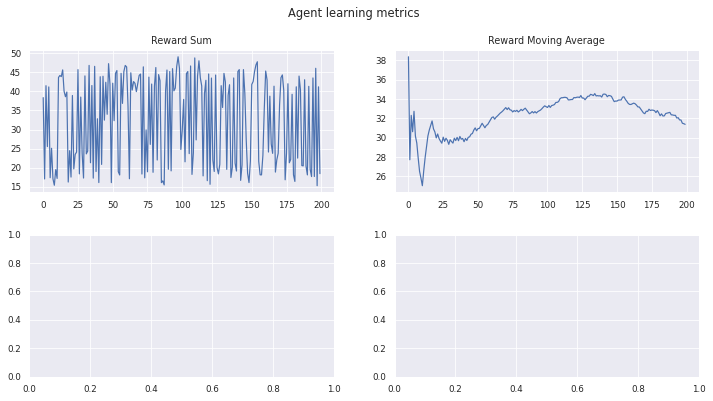

In [ ]:
stats.plot_learning_stats()

### REINFORCE, Actor-Critic, and Rainbow agent

In [ ]:
import pandas as pd

In [ ]:
training_iterations = 3
training_episodes = 100
manager = MovieLensFairnessManager(slate_size=1)

In [ ]:
def run_full_training(agent_class, params, trainings, episodes):
    statistics = []
    for i in range(trainings):
        manager = MovieLensFairnessManager(slate_size=1)
        stats = LearningStatistics()
        agent = agent_class(**params)        
        manager.train(agent, max_episodes=episodes, statistics=stats)
        statistics.append(stats)
    metrics = pd.DataFrame()
    for i in range(len(statistics)):
        stats = pd.DataFrame(statistics[i].collected_metrics)
        stats['model'] = agent_class.__name__
        metrics = pd.concat([metrics, stats])
    metrics.to_csv(f'{agent_class.__name__}_optimized_results.csv', index=False)

In [ ]:
reinforce_params = {
    "n_actions": manager.env.action_space.n,
    "state_size": manager.env.observation_space.shape[0],
    "hidden_layers": [128, 128],
    "discount_factor": 0.9,
    "learning_rate": 0.001,
}
run_full_training(ReinforceAgent, reinforce_params, training_iterations, training_episodes)

Training...
Episode 99 Mean Rewards 32.84 Last Reward 20.06		Training...
Episode 99 Mean Rewards 33.04 Last Reward 22.00		Training...
Episode 99 Mean Rewards 33.40 Last Reward 24.77		

In [ ]:
ac_params = default_params = {
    "n_actions": manager.env.action_space.n,
    "state_size": manager.env.observation_space.shape[0],
    "actor_hidden_layers": [128, 128],
    "critic_hidden_layers": [128, 64],
    "discount_factor": 0.99,
    "actor_learning_rate": 0.001,
    "critic_learning_rate": 0.0001,
}
run_full_training(ActorCriticAgent, ac_params, training_iterations, training_episodes)

Training...
Episode 99 Mean Rewards 26.43 Last Reward 10.00		Training...
Episode 99 Mean Rewards 27.78 Last Reward 10.00		Training...
Episode 99 Mean Rewards 25.52 Last Reward 12.40		

In [ ]:
dqn_params = {
    "output_size": manager.env.action_space.n,
    "input_size": manager.env.observation_space.shape[0],
    "network_update_frequency": 3,
    "network_sync_frequency": 300,
    "priority_importance": 0.4,
    "priority_weigth_growth": 0.01,
    "buffer_size": 10000,
    "buffer_burn_in": 1000,
    "batch_size": 32,
    "noise_sigma": 0.017,
    "discount_factor": 0.95,
    "learning_rate": 0.001,
    "hidden_layers": [512, 512, 128, 128],
}
run_full_training(RainbowDQNAgent, dqn_params, training_iterations, training_episodes)

### DQN Slate

In [ ]:
manager = MovieLensFairnessManager(slate_size=10)

dqn_params = {
    "output_size": manager.env.action_space.nvec[0],
    "input_size": manager.env.observation_space.shape[0],
    "network_update_frequency": 3,
    "network_sync_frequency": 300,
    "priority_importance": 0.4,
    "priority_weigth_growth": 0.01,
    "buffer_size": 10000,
    "buffer_burn_in": 1000,
    "batch_size": 32,
    "noise_sigma": 0.017,
    "discount_factor": 0.95,
    "learning_rate": 0.001,
    "hidden_layers": [512, 512, 128, 128],
}

seeds = 5
dcg_random_results = []
ndcg_random_results = []
dcg_dqn_results = []
ndcg_dqn_results = []

for i in range(seeds):
    manager = MovieLensFairnessManager(slate_size=10)
    agent = RandomAgent(manager.env.action_space)
    stats = LearningStatistics()
    manager.train(rl=agent,statistics=stats,max_episodes=500,should_print=True)
    ndcg_random_results += manager.env.ndcg
    dcg_random_results += manager.env.dcg
    manager = MovieLensFairnessManager(slate_size=10)
    agent = RainbowDQNAgent(**dqn_params)
    stats = LearningStatistics()
    manager.train(rl=agent,statistics=stats,max_episodes=500,should_print=True)
    ndcg_dqn_results += manager.env.ndcg
    dcg_dqn_results += manager.env.dcg

In [ ]:
df = pd.DataFrame({
    'dcg_random':dcg_random_results,
    'ndcg_random':ndcg_random_results,
    'dcg_dqn':dcg_dqn_results,
    'ndcg_dqn':ndcg_dqn_results,
})
df.to_csv('relevance_metrics.csv')
df.describe().to_csv('relevance_metrics_describe.csv')

## Plot comparison

In [ ]:
training_iterations = 1
training_episodes = 300

In [ ]:
manager = MovieLensFairnessManager(slate_size=1)
rainbow_statistics = []

for i in range(training_iterations):
    stats = LearningStatistics()
    rainbow_agent = RainbowDQNAgent(
        manager.env.observation_space.shape[0],
        manager.env.action_space.n,
        network_update_frequency=5,
        network_sync_frequency=250,
        batch_size=32,
        learning_rate=0.00025,
        discount_factor=0.9,
        buffer_size=10000,
        buffer_burn_in=32,
        statistics=stats
    )
    manager.train(rainbow_agent, max_episodes=training_episodes, statistics=stats)
    rainbow_statistics.append(stats)


manager = MovieLensFairnessManager(slate_size=1)
random_statistics = []
for i in range(training_iterations):
    stats = LearningStatistics()
    random_agent = RandomAgent(gym.spaces.Discrete(3883))
    manager.train(random_agent, max_episodes=training_episodes, statistics=stats)
    random_statistics.append(stats)

In [ ]:
manager = MovieLensFairnessManager(slate_size=1)
reinforce_statistics = []
for i in range(training_iterations):
    stats = LearningStatistics()
    reinforce_agent = ReinforceAgent(
        state_size=manager.env.observation_space.shape[0], 
        n_actions=manager.env.action_space.n, 
        discount_factor=0.95,
        learning_rate=0.001)
    manager.train(reinforce_agent, max_episodes=training_episodes, statistics=stats)
    reinforce_statistics.append(stats)


manager = MovieLensFairnessManager(slate_size=1)
ac_statistics = []
for i in range(training_iterations):
    stats = LearningStatistics()
    ac_agent = ActorCriticAgent(
        state_size=manager.env.observation_space.shape[0], 
        n_actions=manager.env.action_space.n, 
        discount_factor=0.99)
    manager.train(ac_agent, max_episodes=training_episodes, statistics=stats)
    ac_statistics.append(stats)

Training...
Episode 299 Mean Rewards 32.62 Last Reward 39.92		Training...
Episode 299 Mean Rewards 29.09 Last Reward 50.00		

In [ ]:
metrics = pandas.DataFrame()
for i in range(len(rainbow_statistics)):
    stats = pandas.DataFrame(rainbow_statistics[i].collected_metrics)
    stats['model'] = 'DuelingDQN'
    metrics = pandas.concat([metrics, stats])
for i in range(len(random_statistics)):
    stats = pandas.DataFrame(random_statistics[i].collected_metrics)
    stats['model'] = 'RandomAgent'
    metrics = pandas.concat([metrics, stats])
for i in range(len(reinforce_statistics)):
    stats = pandas.DataFrame(reinforce_statistics[i].collected_metrics)
    stats['model'] = 'REINFORCE'
    metrics = pandas.concat([metrics, stats])
for i in range(len(ac_statistics)):
    stats = pandas.DataFrame(ac_statistics[i].collected_metrics)
    stats['model'] = 'ActorCritic'
    metrics = pandas.concat([metrics, stats])

metrics.to_csv('all_metrics_test.csv')

In [ ]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
metrics = pandas.read_csv('all_metrics_test.csv', index_col=0)
metrics = metrics.query('metric=="moving_rewards"').reset_index(drop=True)
metrics['measurement'] = metrics.measurement.astype(float)

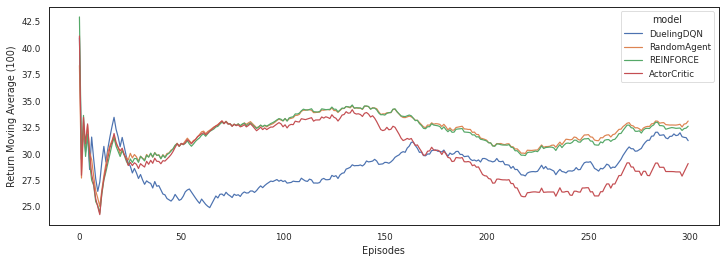

In [ ]:
sns.set(rc={'figure.figsize':(12,4)})
sns.set_context("paper")
sns.set_style("white")
sns.color_palette("Set2")
plot = sns.lineplot(data=metrics, x="episode", y="measurement", hue='model', ci=95, legend='full')
plot.set(xlabel='Episodes', ylabel='Return Moving Average (100)')
plt.savefig("preliminary_results.pdf")